In [1]:
from pandas_datareader import data as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from   scipy.io import loadmat
import time
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

from sklearn.model_selection import StratifiedKFold, cross_val_score  # 导入交叉检验算法
from sklearn.feature_selection import SelectPercentile, f_classif  # 导入特征选择方法库
from sklearn.pipeline import Pipeline  # 导入Pipeline库
from sklearn.metrics import accuracy_score  # 准确率指标
from sklearn.metrics import roc_auc_score
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

# from utility_funcs import *

import warnings
warnings.filterwarnings('ignore')


In [2]:
pre_neutralized_factors = pd.read_pickle('/home/ubuntu/data/factors.pkl')
neutralized_factors = pd.read_pickle('/home/ubuntu/data/neutralized_factors.pkl')
selected_factors = pd.read_pickle('/home/ubuntu/data/selected_factors.pkl')

feature_list = list(selected_factors.index)

print('Finish loading!')

Finish loading!


In [3]:
data = neutralized_factors[['code','day','sector','weekly_return'] + feature_list]
data

,code,day,sector,weekly_return,VOL60,VOL20,VOL5,VOL10,VOL120,ACD6,...,CFO2EV,TVSTD6,Volatility,JDQS20,DDNCR,TVMA20,MoneyFlow20,CTOP,HSIGMA,CCI5
0,4,20180105.0,28,-4.024702,-0.775176,-0.917950,-1.061420,-1.222159,-1.161016,0.764560,...,0.783831,-0.287749,-0.126651,1.940750,-0.199333,-0.268916,-0.268563,-0.397089,-0.441407,0.090599
1,600601,20180105.0,28,-1.355046,-1.246389,-1.201163,-1.220196,-1.228082,-1.201746,-0.507241,...,0.799740,-1.281351,-0.046834,-1.782799,0.605341,-1.400236,-1.399994,-0.217249,-1.758799,0.140573
2,600652,20180105.0,29,13.520729,-0.744055,-0.683546,-0.724665,-0.672548,-0.431911,-0.313788,...,0.002389,-0.900940,-0.865201,-0.269848,-0.297214,-0.631245,-0.631016,0.053134,0.010386,0.663940
3,600602,20180105.0,28,-0.277466,-1.286696,-1.117314,-1.102816,-1.186759,-1.254980,0.030110,...,0.503842,-0.909087,0.451541,-0.265318,-1.361486,-1.121716,-1.121395,0.481633,-0.360316,0.511521
4,600651,20180105.0,16,1.354170,0.663059,0.009371,-0.151267,0.070555,0.069727,0.066070,...,-0.361441,-0.680234,-1.052387,-0.905105,0.814633,-0.344706,-0.345137,0.192816,0.109807,0.292743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573404,300980,20211022.0,6,1.013339,0.478774,-0.493997,-0.906647,-0.926890,1.402471,-0.310812,...,-0.154294,0.435118,1.179695,1.747348,1.026139,0.563466,0.563503,-0.636685,-1.164114,0.013526
573405,605016,20211022.0,6,-1.184309,1.312164,1.556815,0.148629,1.489340,2.500906,-0.562508,...,-0.261223,0.612428,-0.194636,0.095345,1.555047,0.620462,0.620530,-0.673432,1.574468,-0.828693
573406,605098,20211022.0,15,5.422783,0.612101,1.335030,2.713900,2.722779,2.394376,2.049231,...,-0.754029,0.861121,1.551690,0.876572,1.450885,0.623359,0.623791,1.023333,0.898465,1.179519
573407,300975,20211022.0,26,0.603139,1.522815,-0.526855,0.577239,-0.075824,2.010993,0.096832,...,-1.011574,0.258743,0.180997,-0.751500,-0.537888,0.031673,0.032428,0.181428,-0.485219,0.870481


## XGBoost 分类

In [4]:
# 打标签，每个调仓日按照股票的周收益率排序, 前30%为0，中间40%为1, 后30%为2， 
# n_label = 3
# q = [0, 0.3, 0.7, 1]
# data['label'] = data.groupby('day').weekly_return.transform(lambda x: pd.qcut(x, q=q, labels=[2, 1, 0]))
n_label = 12
data['label'] = data.groupby('day').weekly_return.transform(lambda x: pd.qcut(x, n_label, labels=range(n_label-1, -1, -1)))
data

,code,day,sector,weekly_return,VOL60,VOL20,VOL5,VOL10,VOL120,ACD6,...,TVSTD6,Volatility,JDQS20,DDNCR,TVMA20,MoneyFlow20,CTOP,HSIGMA,CCI5,label
0,4,20180105.0,28,-4.024702,-0.775176,-0.917950,-1.061420,-1.222159,-1.161016,0.764560,...,-0.287749,-0.126651,1.940750,-0.199333,-0.268916,-0.268563,-0.397089,-0.441407,0.090599,10
1,600601,20180105.0,28,-1.355046,-1.246389,-1.201163,-1.220196,-1.228082,-1.201746,-0.507241,...,-1.281351,-0.046834,-1.782799,0.605341,-1.400236,-1.399994,-0.217249,-1.758799,0.140573,6
2,600652,20180105.0,29,13.520729,-0.744055,-0.683546,-0.724665,-0.672548,-0.431911,-0.313788,...,-0.900940,-0.865201,-0.269848,-0.297214,-0.631245,-0.631016,0.053134,0.010386,0.663940,0
3,600602,20180105.0,28,-0.277466,-1.286696,-1.117314,-1.102816,-1.186759,-1.254980,0.030110,...,-0.909087,0.451541,-0.265318,-1.361486,-1.121716,-1.121395,0.481633,-0.360316,0.511521,4
4,600651,20180105.0,16,1.354170,0.663059,0.009371,-0.151267,0.070555,0.069727,0.066070,...,-0.680234,-1.052387,-0.905105,0.814633,-0.344706,-0.345137,0.192816,0.109807,0.292743,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573404,300980,20211022.0,6,1.013339,0.478774,-0.493997,-0.906647,-0.926890,1.402471,-0.310812,...,0.435118,1.179695,1.747348,1.026139,0.563466,0.563503,-0.636685,-1.164114,0.013526,3
573405,605016,20211022.0,6,-1.184309,1.312164,1.556815,0.148629,1.489340,2.500906,-0.562508,...,0.612428,-0.194636,0.095345,1.555047,0.620462,0.620530,-0.673432,1.574468,-0.828693,4
573406,605098,20211022.0,15,5.422783,0.612101,1.335030,2.713900,2.722779,2.394376,2.049231,...,0.861121,1.551690,0.876572,1.450885,0.623359,0.623791,1.023333,0.898465,1.179519,1
573407,300975,20211022.0,26,0.603139,1.522815,-0.526855,0.577239,-0.075824,2.010993,0.096832,...,0.258743,0.180997,-0.751500,-0.537888,0.031673,0.032428,0.181428,-0.485219,0.870481,3


In [6]:
# 4/5 作为训练集，1/5作为测试集
train_data = data.iloc[:int(len(data)*0.8)]
test_data = data.iloc[int(len(data)*0.8):]
# 获取特征及标签
X_train = train_data[feature_list]
y_train = train_data['label']
X_test = test_data[feature_list]
y_test = test_data['label']
# 获取模型
xgb_model =  XGBClassifier(booster='gbtree', n_estimators=1000, max_depth=3, subsample=0.9,
                           random_state=42 , objective ='multi:softprob', num_class = n_label, 
                           tree_method='gpu_hist', eta=0.05)

In [7]:
# 模型训练
starttime = datetime.now()
print ('开始训练模型')
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model.fit(X_train, y_train, eval_set=eval_set, eval_metric=['merror', 'auc', 'mlogloss'], verbose=False)
endtime = datetime.now()
print ('模型运行时长：',int((endtime - starttime).seconds/60),'分钟')

开始训练模型
模型运行时长： 2 分钟


In [8]:
# evaluate train performance
yhat = xgb_model.get_booster().predict(xgb.DMatrix(X_train))
# xgb_model.get_booster().predict(xgb.DMatrix(X_train))
score = accuracy_score(y_train, yhat.argmax(1))
print('Train Accuracy: %.3f' % score)

Train Accuracy: 0.166


In [9]:
# evaluate test performance
# yhat_test = clf_gpu.predict(xgb.DMatrix(X_test))
yhat_test = xgb_model.get_booster().predict(xgb.DMatrix(X_test))
score_test = accuracy_score(y_test, yhat_test.argmax(1))
print('Test Accuracy: %.3f' % score_test)

Test Accuracy: 0.130


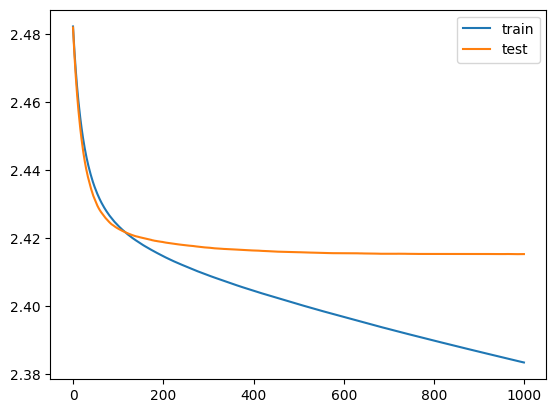

In [10]:
# retrieve performance metrics
# results = clf_gpu.evals_result()
plt.plot(xgb_model.evals_result()['validation_0']['mlogloss'], label='train')
plt.plot(xgb_model.evals_result()['validation_1']['mlogloss'], label='test')
plt.legend()
plt.show()


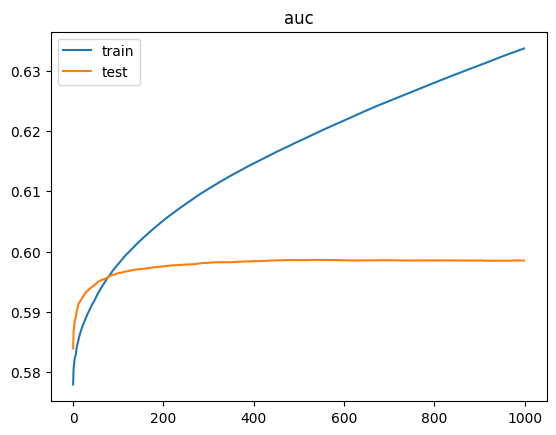

In [11]:
# ['merror', 'auc', 'mlogloss']
plt.plot(xgb_model.evals_result()['validation_0']['auc'], label='train')
plt.plot(xgb_model.evals_result()['validation_1']['auc'], label='test')
plt.title('auc')
plt.legend()
plt.show()
# xgb_model.evals_result()['validation_0'].keys()

<Axes: >

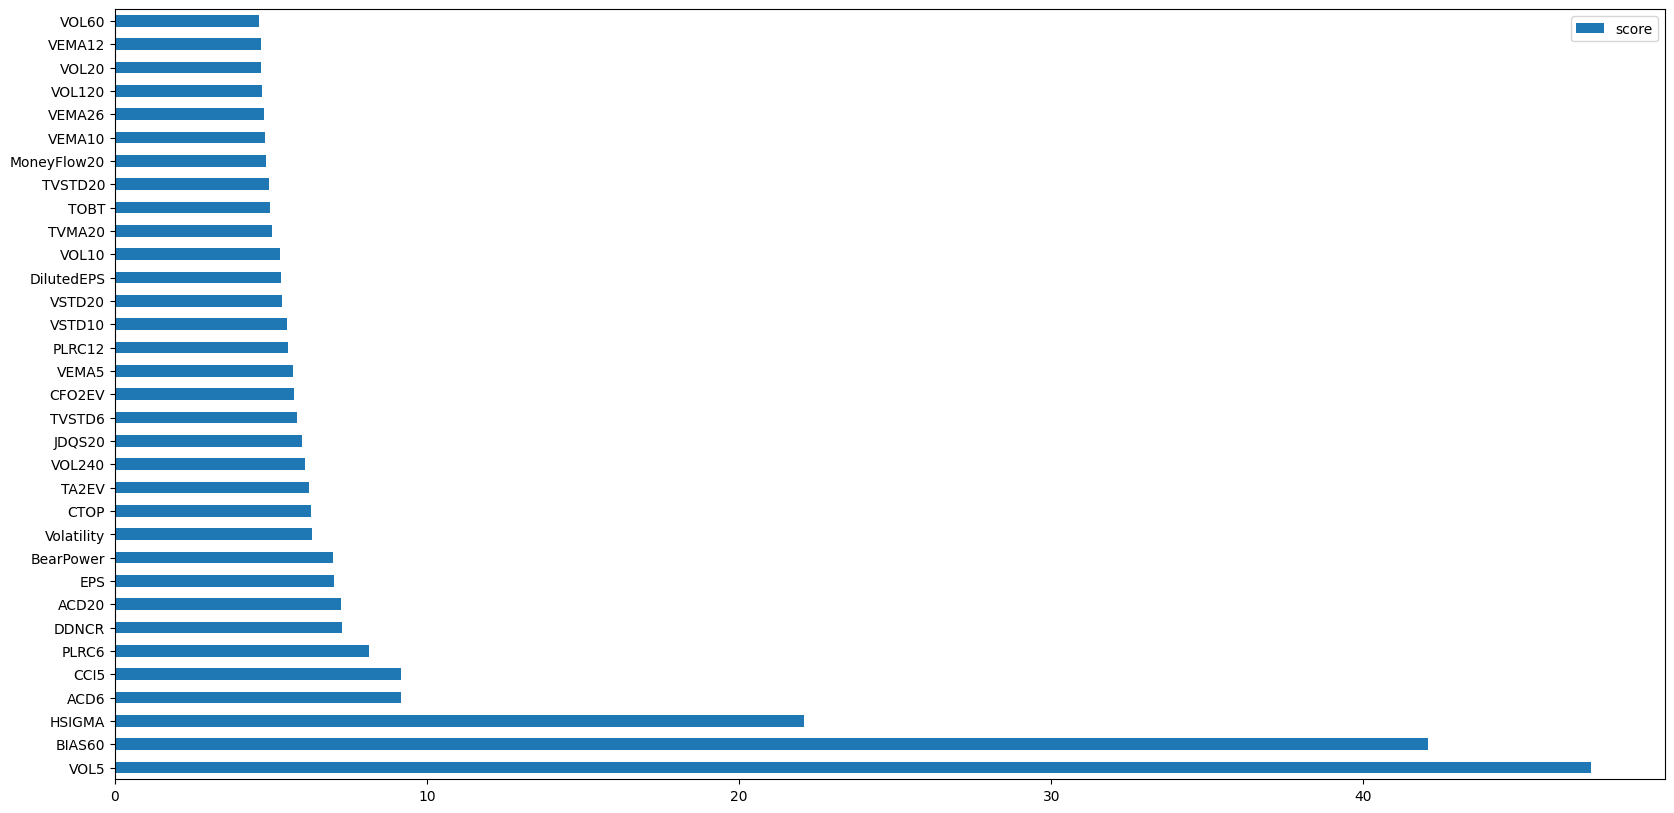

In [12]:
# 特征重要性
feature_important = xgb_model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

d = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
d.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

### 回测

#### 等权持有概率最高的n_stock支股票

In [13]:
test_data['y_pred'] = xgb_model.get_booster().predict(xgb.DMatrix(X_test)).argmax(1)
test_data['y_prob'] = xgb_model.get_booster().predict(xgb.DMatrix(X_test)).max(1)
test_data

,code,day,sector,weekly_return,VOL60,VOL20,VOL5,VOL10,VOL120,ACD6,...,JDQS20,DDNCR,TVMA20,MoneyFlow20,CTOP,HSIGMA,CCI5,label,y_pred,y_prob
458727,300588,20210226.0,28,7.014680,-0.166624,-0.453745,-0.296233,-0.244678,2.212852,0.567543,...,0.419968,-0.955908,0.655726,0.656432,-0.102067,0.583976,1.958572,1,11,0.114239
458728,603035,20210226.0,13,4.086542,-0.208201,-0.330222,-0.637782,-0.342009,0.152024,0.114476,...,-1.371366,0.365398,-0.055249,-0.054971,1.007634,-0.046324,-0.331149,4,5,0.116646
458729,2838,20210226.0,6,-2.378696,0.318808,-0.218187,-0.483593,-0.476062,-0.036020,0.167201,...,-1.334567,-2.021552,-0.566161,-0.566866,0.536169,1.868589,0.491787,10,8,0.104124
458730,603228,20210226.0,26,3.946459,-1.098036,-1.024061,-0.976244,-0.972639,-1.108704,0.626794,...,0.030079,1.263304,-2.572620,-2.572843,-0.061485,-1.455614,2.084927,4,8,0.131133
458731,603877,20210226.0,17,10.502958,-0.506637,-0.540252,-0.505228,-0.554988,-0.366875,1.543071,...,1.230868,-1.104623,-1.377928,-1.377963,0.205946,1.086508,0.562171,0,11,0.151341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573404,300980,20211022.0,6,1.013339,0.478774,-0.493997,-0.906647,-0.926890,1.402471,-0.310812,...,1.747348,1.026139,0.563466,0.563503,-0.636685,-1.164114,0.013526,3,5,0.139247
573405,605016,20211022.0,6,-1.184309,1.312164,1.556815,0.148629,1.489340,2.500906,-0.562508,...,0.095345,1.555047,0.620462,0.620530,-0.673432,1.574468,-0.828693,4,0,0.091937
573406,605098,20211022.0,15,5.422783,0.612101,1.335030,2.713900,2.722779,2.394376,2.049231,...,0.876572,1.450885,0.623359,0.623791,1.023333,0.898465,1.179519,1,11,0.249347
573407,300975,20211022.0,26,0.603139,1.522815,-0.526855,0.577239,-0.075824,2.010993,0.096832,...,-0.751500,-0.537888,0.031673,0.032428,0.181428,-0.485219,0.870481,3,9,0.100756


,持有股票数,总周数,盈利周数,亏损周数,胜率
0,20.0,35.0,18.0,17.0,0.514286
1,30.0,35.0,18.0,17.0,0.514286
2,50.0,35.0,22.0,13.0,0.628571
3,80.0,35.0,23.0,12.0,0.657143
4,100.0,35.0,23.0,12.0,0.657143
5,130.0,35.0,23.0,12.0,0.657143


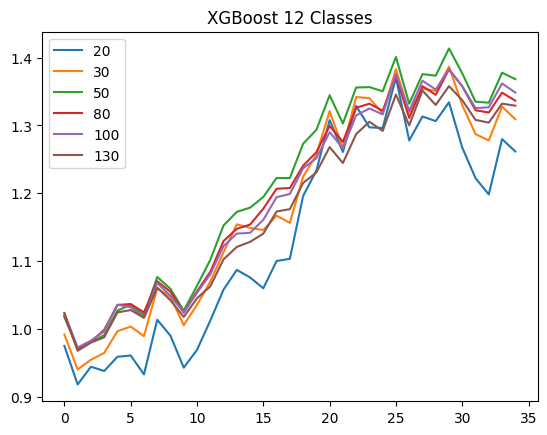

In [14]:
win_lose_df = pd.DataFrame(columns=['持有股票数','总周数','盈利周数','亏损周数','胜率'])
for n_stock in [20, 30, 50, 80, 100,130]:
    # 记录胜率
    a=test_data[(test_data.y_pred==0)].groupby('day').apply(lambda x: (x.sort_values('y_prob',ascending=False)[:n_stock]['weekly_return'].mean()))
    temp = pd.DataFrame.from_dict({'持有股票数':n_stock,'总周数':len(a.values),'盈利周数':sum(a.values>0),'亏损周数': sum(a.values<0),'胜率':sum(a.values>0) / len(a)},orient='index').T
    win_lose_df = pd.concat((win_lose_df, temp),ignore_index=True)
    # 画图
    plt.plot((a.values/100).cumsum()+1, label=n_stock)
plt.legend()
plt.title('XGBoost 12 Classes')

win_lose_df


## XGBoost 回归 （Todo)

## 线性回归 (Todo)